In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from scipy.stats import expon

from tensorflow import keras
from tensorflow.keras import layers
from random import randint

from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train: (60000, 28, 28)
yhat_train: (60000,)
X_test:  (10000, 28, 28)
yhat_test:  (10000,)


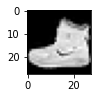

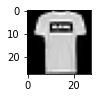

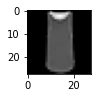

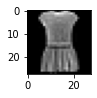

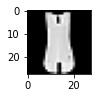

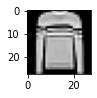

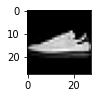

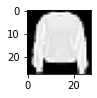

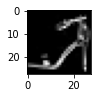

In [2]:
print('X_train: ' + str(X_train.shape))
print('yhat_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('yhat_test:  '  + str(y_test.shape))

for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.show()

In [3]:
#Pre-Processing normalization and Data Organization. 

# Change integers to floats.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = np.int32(np.array(y_train))
y_test = np.int32(np.array(y_test))

# Normalize to range 0-1.  White to black have range of 0-255
X_train = X_train / 255.0 
X_test = X_test / 255.0


# # #target values, only run this once. 
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [5]:
def submatrix(matrix, start_row, start_col, width, height):
    return matrix[start_row:start_row+height, start_col:start_col+width]

In [6]:
def conv(x, w):
    step = 1
    xsize1, ysize1, num_filters = w.shape[0], w.shape[1], w.shape[2]
    rows, columns = x.shape
    c1_rows = (rows - ysize1) // step + 1
    c1_columns = (columns - xsize1) // step + 1
    
    
    c1 = np.zeros((c1_rows, c1_columns, num_filters))
    
    # Convolution
    for f in range(num_filters):
        i, p = 0, 0 
        z1 = []
        while rows >= (i + ysize1):
            while columns >= (p + xsize1):
                
                sub = submatrix(x, i, p, xsize1, ysize1)
                # zout1 = np.sum(sub * w)  # Use element-wise multiplication and sum
                zout1 = np.sum(sub * w[:,:,f]) #+ b  # Add bias term
                z1.append(zout1)
                
                p += step
    
            p = 0 
            i += step
    
        z1 = np.array(z1)
        c1[:,:,f] = np.reshape(z1, (c1_rows, c1_columns))
    
    return c1

In [7]:
def relu(z):
    return np.maximum(z,0)

In [8]:
def fwdpass(xdata, w, k, output_classes, b):
   
    # Layer 1
    c = conv(xdata, w)
    r = relu(c)
    

    conn = np.zeros((output_classes, 1))
    for i in range(output_classes):
        weights = k[i,:,:,:]
        out = np.multiply(weights, r)
        
        conn[i] = np.sum(out) + b[i]
    
    return conn, c, r

In [9]:
def softmax_function(z):
    ZZ = np.exp(z - max(z))/np.sum(np.exp(z - max(z)))
    return ZZ

In [10]:
def softmax_derivative(smax, true_labels):
    # Ensure both smax and true_labels are 1D arrays
    smax = np.squeeze(smax)
    true_labels = np.squeeze(true_labels)
    
    der = smax - true_labels
    return der

def bias_derivative(der):
    return der


def fc_derivative(smax_der, r, output_classes):
    diff_k = np.zeros((output_classes, r.shape[0], r.shape[1], r.shape[2]))
    for i in range(output_classes):
        diff_k[i,:,:,:] = smax_der[i]*r
    return diff_k

def gradient_Relu(c):
    grad_relu = np.where(c>0,1,0)
    return grad_relu
    
def relu_der(smax_der, r, k, c, x):
    delta = np.zeros(r.shape)
    for i in range(r.shape[0]):
        for j in range(r.shape[1]):
            for p in range(r.shape[2]):
                delta[i,j,p] = np.sum(np.multiply(smax_der, k[:,i,j,p]))

    relu_grad = np.multiply(gradient_Relu(c), delta)
    diff_w = conv(x, relu_grad)
    return diff_w
            

In [11]:
def backwardpass(smax, y, c, r, k, w, bias, output_classes, x):
    smax_der = softmax_derivative(smax, y)
            
    der_bias = bias_derivative(smax_der)

    diff_k = fc_derivative(smax_der, r, output_classes)

    diff_w = relu_der(smax_der, r, k, c, x)

    return diff_w, diff_k, der_bias

In [12]:
def parameter_update(bias, der_bias, k, der_k, w, der_w, LR):
    der_bias = der_bias.reshape(-1, 1)
    bias = bias - LR*der_bias
    k = k - LR*der_k
    w = w - LR*der_w
    return bias, k, w

In [13]:
output_classes = 10
total_inputs = len(X_train)
output_size = 10
num_filters=5
filter_size=3
input_dim=28
input_size=28*28

K = np.random.randn(filter_size,filter_size, num_filters)/ np.sqrt(filter_size)
W = np.random.randn(output_size,input_dim-filter_size+1,input_dim-filter_size+1,num_filters) / np.sqrt(input_dim-filter_size+1)
bias= np.zeros((output_size, 1))/np.sqrt(output_size)

In [14]:
def train_model(X_train, y_train, output_classes, W, K, bias):
    LR = .01
    num_epochs = 10

    for epochs in range(num_epochs):

        if (epochs > 5):
            LR = 0.001
        if (epochs > 10):
            LR = 0.0001
        if (epochs > 15):
            LR = 0.00001

        total_correct = 0

        for n in range(len(X_train)):

            
            y = y_train[n]
            x = X_train[n][:]


            #forward propagation
            U, Z, H = fwdpass(x, K, W, output_classes, bias)

            rho = softmax_function(U)  

            predicted_value = np.argmax(rho) 

            if (predicted_value == np.argmax(y)):
                total_correct += 1


            #backward propagation

            diff_U = np.squeeze(rho) - np.squeeze(y)


            diff_K, diff_W, diff_bias = backwardpass(rho, y, Z, H, W, K, bias, output_classes, x)

            #Parameter update

            bias, W, K = parameter_update(bias, diff_bias, W, diff_W, K, diff_K, LR)

        print("Training accuracy for epoch {} : {}".format(epochs+1, total_correct/np.float(len(X_train))))
    return W, K, bias

In [15]:
def test_model(X_test, y_test, output_classes, W, K, bias):

    total_correct = 0

    for n in range(len(X_test)):


        y = y_test[n]
        x = X_test[n][:]


        #forward propagation
        U, Z, H = fwdpass(x, K, W, output_classes, bias)

        rho = softmax_function(U)  

        predicted_value = np.argmax(rho) 

        if (predicted_value == np.argmax(y)):
            total_correct += 1


    print("Testing accuracy: {}".format(total_correct/np.float(len(X_test))))

In [16]:
W, K, bias = train_model(X_train, y_train, output_classes, W, K, bias)

<ipython-input-14-43e4fb9e8c77>:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print("Training accuracy for epoch {} : {}".format(epochs+1, total_correct/np.float(len(X_train))))


Training accuracy for epoch 1 : 0.8168333333333333
Training accuracy for epoch 2 : 0.8580666666666666
Training accuracy for epoch 3 : 0.86875
Training accuracy for epoch 4 : 0.87655
Training accuracy for epoch 5 : 0.8820833333333333
Training accuracy for epoch 6 : 0.8866166666666667
Training accuracy for epoch 7 : 0.9046666666666666
Training accuracy for epoch 8 : 0.9067666666666667
Training accuracy for epoch 9 : 0.9078
Training accuracy for epoch 10 : 0.9087333333333333


In [17]:
test_model(X_test, y_test, output_classes, W, K, bias)

Testing accuracy: 0.8814


<ipython-input-15-50d9d231ba81>:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print("Testing accuracy: {}".format(total_correct/np.float(len(X_test))))
